# Edge detection with openCV

This notebook makes use of `openCV` and the [Canny edge detection](https://en.wikipedia.org/wiki/Canny_edge_detector) to extract edges as a proxy for shape. Later we only use those edges that are in the bounding box database for imagenette created earlier.

In [1]:
import cv2
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path

Read in a sample image to check edge detection

In [2]:
save_path = Path("data/")

In [3]:
image_path = save_path / "imagenette2/train/n03028079/n03028079_28243.JPEG"

# read imagenette sample image
image = cv2.imread(str(image_path), cv2.COLOR_BGR2RGB)

Blurring also helps

In [4]:
blurred = cv2.fastNlMeansDenoisingColored(image, None, 30, 10, 7, 21)
blurred = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

Canny needs a grayscale image to work properly

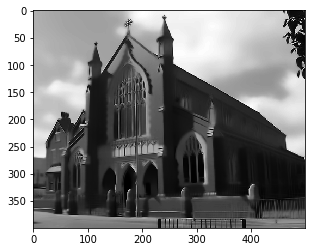

In [5]:
plt.imshow(blurred, cmap = plt.cm.gray)

Perform canny edge detection

In [6]:
# perform edge detection
edges = cv2.Canny(blurred, 30, 100)

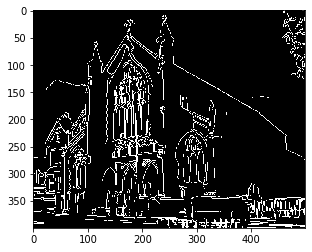

In [7]:
plt.imshow(edges, cmap = plt.cm.gray)

As we can see the result is not very good and can be improved.

Finetuning parameters takes time, however. Because we want to automatize it anyway, we need a automatic choice for the parameters.

_____

## Automatize edge detection

To only perform edge detection on the images we actually will use, we need to load in the imagenette bounding boxes dataset we created earlier

In [8]:
imgn_data_flt = pd.read_pickle(save_path / "imagenette_boundingboxes.pkl")

In [9]:
imgn_data_flt[:5]

,folder,filename,segmented,source.database,size.width,size.height,size.depth,object.name,object.pose,object.truncated,object.difficult,object.bndbox.xmin,object.bndbox.ymin,object.bndbox.xmax,object.bndbox.ymax,object
0,n03445777,n03445777_5901,0,ImageNet database,500,334,3,n03445777,Unspecified,0,0,249,112,455,303,NaN
1,n03445777,n03445777_8145,0,ImageNet database,500,375,3,n03445777,Unspecified,0,0,79,127,294,339,NaN
2,n03445777,n03445777_3928,0,ImageNet database,500,333,3,n03445777,Unspecified,0,0,131,148,238,256,NaN
3,n03445777,n03445777_10304,0,ImageNet database,500,375,3,n03445777,Unspecified,0,0,64,0,341,265,NaN
4,n03445777,n03445777_9971,0,ImageNet database,500,375,3,n03445777,Unspecified,0,0,95,41,379,330,NaN


Since we do not use the original sized image in the network, but a `256` resize with `224` center crop, we need to adjust the bounding boxes accordingly!

The columns we need have the following indexes:

In [10]:
xmax_index = imgn_data_flt.columns.get_loc("object.bndbox.xmax")
xmin_index = imgn_data_flt.columns.get_loc("object.bndbox.xmin")

ymax_index = imgn_data_flt.columns.get_loc("object.bndbox.ymax")
ymin_index = imgn_data_flt.columns.get_loc("object.bndbox.ymin")

szh_index = imgn_data_flt.columns.get_loc("size.height")
szw_index = imgn_data_flt.columns.get_loc("size.width")

In [11]:
for row in imgn_data_flt.itertuples():
    # get the value for the index
    # add +1 because index is first "column" in the tuple
    xmin = row[xmin_index + 1]
    xmax = row[xmax_index + 1]
    ymin = row[ymin_index + 1]
    ymax = row[ymax_index + 1]
    
    height = row[szh_index + 1]
    width = row[szw_index + 1]
    
    # new values for x dimension
    x_change = 256 / int(width)
    xmax_n = int(x_change * int(xmax) - 16)
    xmax_n = min(xmax_n, 224)
    xmin_n = int(x_change * int(xmin) - 16)
    xmin_n = max(xmin_n, 0)
    # new values for y dimension
    y_change = 256 / int(height)
    ymax_n = int(y_change * int(ymax) - 16)
    ymax_n = min(ymax_n, 224)
    ymin_n = int(y_change * int(ymin) - 16)
    ymin_n = max(ymin_n, 0)
    # save to dataframe
    imgn_data_flt.at[row[0], "xmax_n"] = xmax_n
    imgn_data_flt.at[row[0], "xmin_n"] = xmin_n
    imgn_data_flt.at[row[0], "ymax_n"] = ymax_n
    imgn_data_flt.at[row[0], "ymin_n"] = ymin_n

In [12]:
 imgn_data_flt[:5]

,folder,filename,segmented,source.database,size.width,size.height,size.depth,object.name,object.pose,object.truncated,object.difficult,object.bndbox.xmin,object.bndbox.ymin,object.bndbox.xmax,object.bndbox.ymax,object,xmax_n,xmin_n,ymax_n,ymin_n
0,n03445777,n03445777_5901,0,ImageNet database,500,334,3,n03445777,Unspecified,0,0,249,112,455,303,NaN,216.0,111.0,216.0,69.0
1,n03445777,n03445777_8145,0,ImageNet database,500,375,3,n03445777,Unspecified,0,0,79,127,294,339,NaN,134.0,24.0,215.0,70.0
2,n03445777,n03445777_3928,0,ImageNet database,500,333,3,n03445777,Unspecified,0,0,131,148,238,256,NaN,105.0,51.0,180.0,97.0
3,n03445777,n03445777_10304,0,ImageNet database,500,375,3,n03445777,Unspecified,0,0,64,0,341,265,NaN,158.0,16.0,164.0,0.0
4,n03445777,n03445777_9971,0,ImageNet database,500,375,3,n03445777,Unspecified,0,0,95,41,379,330,NaN,178.0,32.0,209.0,11.0


Save modifed data with adpted bounding boxes to pickle

In [13]:
with open(save_path / "imgn_data_flt.pkl", 'wb') as f:
    pickle.dump(imgn_data_flt, f)

A function to do the preprocessing needed for canny

In [14]:
def preprocess_image(imagePath):
    image = cv2.imread(str(imagePath))
    
    blurred = cv2.fastNlMeansDenoisingColored(image, None, 30, 10, 7, 21)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    
    return gray

The automatic chpoice of the lower and upper values allows for quicker processing

In [15]:
# as seen in 
# https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
def auto_canny(image, sigma=0.9):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
 
    # return the edged image
    return edged

`auto_canny` gives us a much better quality than the naive approach

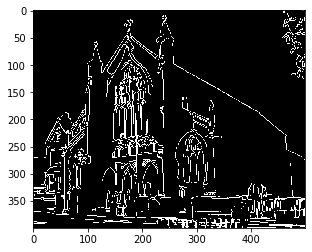

In [16]:
plt.imshow(auto_canny(blurred), cmap = plt.cm.gray)

Check if everything worked as expected

In [17]:
"n03445777_5901" in list(imgn_data_flt['filename'])

True

We need a list of the files we want to analyze. We do not want to have those of the `validation` set and only want to use those that are present in our data

In [18]:
imgn_fns = list(imgn_data_flt['filename'])

# for now we filter out those that would be in the original ImageNet validation set
imgn_pict = [filename for filename in Path(save_path / 'imagenette2/').rglob('*.JPEG') 
             if '_val_' not in filename.name
            if filename.name.split(".")[0] in imgn_fns]

print(imgn_pict[:10])
print(f'\nTotal images: {len(imgn_pict)}')

[PosixPath('data/imagenette2/train/n03394916/n03394916_23108.JPEG'), PosixPath('data/imagenette2/train/n03394916/n03394916_59626.JPEG'), PosixPath('data/imagenette2/train/n03394916/n03394916_5529.JPEG'), PosixPath('data/imagenette2/train/n03394916/n03394916_32997.JPEG'), PosixPath('data/imagenette2/train/n03394916/n03394916_61934.JPEG'), PosixPath('data/imagenette2/train/n03394916/n03394916_59745.JPEG'), PosixPath('data/imagenette2/train/n03394916/n03394916_29164.JPEG'), PosixPath('data/imagenette2/train/n03394916/n03394916_7547.JPEG'), PosixPath('data/imagenette2/train/n03394916/n03394916_37694.JPEG'), PosixPath('data/imagenette2/train/n03394916/n03394916_42673.JPEG')]

Total images: 4312


Save list of paths to pickle to be able to use it in other notebooks and scripts

In [19]:
with open(save_path / "imgn_pict.pkl", 'wb') as f:
    pickle.dump(imgn_pict, f)

Because we will produce a lot of data, we write it out line by line to not have to keep it in memory

Look [here](https://stackoverflow.com/questions/50274063/find-coordinates-of-a-canny-edge-image-opencv-python) for a description on how the coordinates are extracted.
In short: `np.where()` gets the indexes and with `zip()` the list of tuples with that index is created.

[This](https://stackoverflow.com/questions/34667282/numpy-where-detailed-step-by-step-explanation-examples) is a explanation on how `np.where` works in detail.
> When `a` is a 2d array, `np.where()` returns an array of row idx's, and an array of col idx's:

In [20]:
def write_edges(filename, bbox_data=None):
    
    with open(filename,'w') as file:
        # loop over the images
        for imagePath in tqdm(imgn_pict):
            # load the image, convert it to grayscale, and blur it slightly
            pre_image = preprocess_image(imagePath)

            # apply Canny edge detection
            edges = auto_canny(pre_image)

            # get edge coordinates
            indices = np.where(edges != [0])
            coordinates = list(zip(indices[0], indices[1]))
            
            fname_wos = imagePath.name.split('.')[0]
            
            if bbox_data is not None:
                xmin = bbox_data.at[fname_wos, "xmin_n"]
                xmax = bbox_data.at[fname_wos,"xmax_n"]
                ymin = bbox_data.at[fname_wos,"ymin_n"]
                ymax = bbox_data.at[fname_wos,"ymax_n"]
                
                # only save canny edge coordinates within bounding box
                coordinates = [(x,y) for x,y in coordinates if x >= xmin and x <= xmax and y >= ymin and y <= ymax]

            # save to disk
            file.write(f'{fname_wos}\t{coordinates}\n')

Create the file

In [21]:
write_edges(save_path / "edges_data.csv")

100%|██████████| 4312/4312 [1:02:36<00:00,  1.15it/s]


## Subset with edges within the bounding boxes

For now we have created a file with all edges. We also need one only with those within the bounding box

In [22]:
imgn_data_flt.set_index(['filename'], drop=False, inplace=True)
imgn_data_flt[:5]

,folder,filename,segmented,source.database,size.width,size.height,size.depth,object.name,object.pose,object.truncated,object.difficult,object.bndbox.xmin,object.bndbox.ymin,object.bndbox.xmax,object.bndbox.ymax,object,xmax_n,xmin_n,ymax_n,ymin_n
filename,,,,,,,,,,,,,,,,,,,,
n03445777_5901,n03445777,n03445777_5901,0,ImageNet database,500,334,3,n03445777,Unspecified,0,0,249,112,455,303,NaN,216.0,111.0,216.0,69.0
n03445777_8145,n03445777,n03445777_8145,0,ImageNet database,500,375,3,n03445777,Unspecified,0,0,79,127,294,339,NaN,134.0,24.0,215.0,70.0
n03445777_3928,n03445777,n03445777_3928,0,ImageNet database,500,333,3,n03445777,Unspecified,0,0,131,148,238,256,NaN,105.0,51.0,180.0,97.0
n03445777_10304,n03445777,n03445777_10304,0,ImageNet database,500,375,3,n03445777,Unspecified,0,0,64,0,341,265,NaN,158.0,16.0,164.0,0.0
n03445777_9971,n03445777,n03445777_9971,0,ImageNet database,500,375,3,n03445777,Unspecified,0,0,95,41,379,330,NaN,178.0,32.0,209.0,11.0


In [23]:
type(imgn_data_flt.at["n03445777_5901","object.bndbox.xmin"])

str

Some columns are saved as strings even though they should be numeric. Because we use some math operators in our function we are going to call, we have to fix that.

In [24]:
imgn_data_flt.iloc[:,3:7] = imgn_data_flt.iloc[:,xmin_index:ymax_index].apply(pd.to_numeric)

Now we can filter out those regions that are not on the bounding box area

In [25]:
write_edges(save_path / 'edges_data_flt.csv', bbox_data=imgn_data_flt)

100%|██████████| 4312/4312 [1:01:02<00:00,  1.18it/s]


___

## Visualizations

In [26]:
import seaborn as sns

from ast import literal_eval

In [27]:
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [28]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino'], 'size' : 11})
rc('text', usetex=True)

In [29]:
edges_flt = pd.read_csv(save_path / 'edges_data_flt.csv', sep='\t', header=None)

Let's set new headers for our dataframe

In [30]:
edges_flt.columns = ['filename', 'edges']
edges_flt[:5]

,filename,edges
0,n03394916_23108,"[(24, 90), (24, 91), (25, 91), (25, 111), (25,..."
1,n03394916_59626,"[(176, 223), (176, 224), (177, 221), (177, 222..."
2,n03394916_5529,"[(40, 130), (40, 131), (40, 132), (40, 133), (..."
3,n03394916_32997,"[(49, 12), (49, 13), (50, 13), (50, 14), (50, ..."
4,n03394916_61934,"[(74, 211), (74, 212), (74, 213), (74, 214), (..."


Unfortunately, the `edges` was read in as a string and not as a data type list with integers. We have to fix that.

**Note**: This may take a while!

In [31]:
edges_flt['edges'] = edges_flt.edges.apply(literal_eval)

Would be nice to know how many edges each picture has...

In [32]:
edges_flt['edgeslength'] = edges_flt['edges'].str.len()
edges_flt[:5]

,filename,edges,edgeslength
0,n03394916_23108,"[(24, 90), (24, 91), (25, 91), (25, 111), (25,...",514
1,n03394916_59626,"[(176, 223), (176, 224), (177, 221), (177, 222...",691
2,n03394916_5529,"[(40, 130), (40, 131), (40, 132), (40, 133), (...",1660
3,n03394916_32997,"[(49, 12), (49, 13), (50, 13), (50, 14), (50, ...",2629
4,n03394916_61934,"[(74, 211), (74, 212), (74, 213), (74, 214), (...",1100


Some basic descriptive insights

In [33]:
edges_flt['edgeslength'].describe(include='all')

count     4312.000000
mean      1208.234230
std       1589.012876
min          0.000000
25%        157.750000
50%        660.000000
75%       1645.500000
max      14616.000000
Name: edgeslength, dtype: float64

We may have some outliers here!

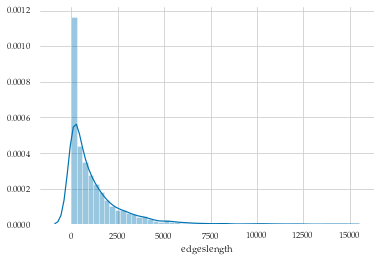

In [34]:
sns.distplot(edges_flt['edgeslength'])
sns.despine(bottom = True, left = True)

Yes!

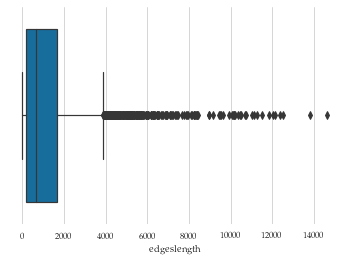

In [35]:
sns.boxplot(x=edges_flt['edgeslength'])
sns.despine(bottom = True, left = True)

Filter out outliers based on the `99%` quantile

In [36]:
q = edges_flt['edgeslength'].quantile(0.90)

Plot without otliers

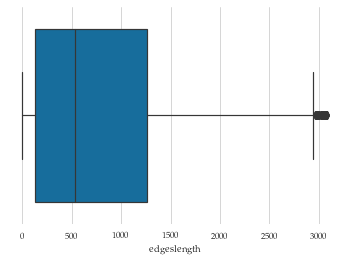

In [37]:
sns.boxplot(x=edges_flt[edges_flt['edgeslength'] < q]['edgeslength'])
sns.despine(bottom = True, left = True)

In [38]:
edges_flt['edges'][:5]

0    [(24, 90), (24, 91), (25, 91), (25, 111), (25,...
1    [(176, 223), (176, 224), (177, 221), (177, 222...
2    [(40, 130), (40, 131), (40, 132), (40, 133), (...
3    [(49, 12), (49, 13), (50, 13), (50, 14), (50, ...
4    [(74, 211), (74, 212), (74, 213), (74, 214), (...
Name: edges, dtype: object

In [39]:
x_val = [elem[0] for lst in edges_flt['edges'] for elem in lst]
y_val = [elem[1] for lst in edges_flt['edges'] for elem in lst]

Visualize the parts of the image with where the edges were detected (within the bounding boxes). 

Image sizes differ, however. To get representative picture, we should scale the data beforehand.

**Note:** takes long to compute!

In [40]:
#sns.jointplot(x_val, y_val, kind="kde")

Let's use `pd.sample()` to visualize `500` random entries, since the complete analysis takes quite some time.

In [41]:
edges_smpl = edges_flt.sample(n=500)
edges_smpl[:5]

,filename,edges,edgeslength
3572,n03000684_31000,"[(99, 190)]",1
2884,n03028079_9674,"[(5, 35), (5, 36), (5, 37), (5, 38), (5, 39), ...",2013
381,n01440764_7846,"[(48, 111), (48, 118), (48, 129), (48, 132), (...",457
2285,n03888257_11187,[],0
1824,n03417042_2386,"[(30, 36), (30, 37), (30, 38), (30, 39), (31, ...",1335


In [42]:
x_val_s = [elem[0] for lst in edges_smpl['edges'] for elem in lst]
y_val_s = [elem[1] for lst in edges_smpl['edges'] for elem in lst]

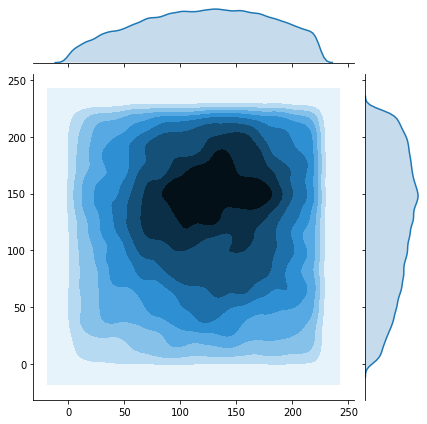

In [92]:
sns.jointplot(x_val_s, y_val_s, kind="kde")
sns.despine(bottom = True, left = True)